# Notes to Improve Workflow

In [1]:
# Setup matplotlib to plot inline (within the notebook)
%matplotlib inline
# Import the pyplot module of Matplotlib as plt
import matplotlib.pyplot as plt
# Import pandas under the abbreviation 'pd'
import pandas as pd
# Import NumPy under the abbreviation 'np'
import numpy as np
# Libraries to aid in web scraping
import requests
from bs4 import BeautifulSoup
from datetime import datetime
#Notes for efficienccy:
#shift + tab when cursor is in arguments to bring up its documentation
#ex: pd.DataFrame(Shift+tab here)
#recall: Json == Dictionary
#to know functions of pandas:
dir(pd)

['BooleanDtype',
 'Categorical',
 'CategoricalDtype',
 'CategoricalIndex',
 'DataFrame',
 'DateOffset',
 'DatetimeIndex',
 'DatetimeTZDtype',
 'ExcelFile',
 'ExcelWriter',
 'Flags',
 'Float32Dtype',
 'Float64Dtype',
 'Float64Index',
 'Grouper',
 'HDFStore',
 'Index',
 'IndexSlice',
 'Int16Dtype',
 'Int32Dtype',
 'Int64Dtype',
 'Int64Index',
 'Int8Dtype',
 'Interval',
 'IntervalDtype',
 'IntervalIndex',
 'MultiIndex',
 'NA',
 'NaT',
 'NamedAgg',
 'Period',
 'PeriodDtype',
 'PeriodIndex',
 'RangeIndex',
 'Series',
 'SparseDtype',
 'StringDtype',
 'Timedelta',
 'TimedeltaIndex',
 'Timestamp',
 'UInt16Dtype',
 'UInt32Dtype',
 'UInt64Dtype',
 'UInt64Index',
 'UInt8Dtype',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__docformat__',
 '__file__',
 '__getattr__',
 '__git_version__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_hashtable',
 '_is_numpy_dev',
 '_lib',
 '_libs',
 '_np_version_under1p18',
 '_testing',
 '_tslib',
 '_typing',
 

# Reading The Data

In [2]:
# using pandas and read_csv()
acquis = pd.read_csv("datasets/startups/acquisitions.csv")
additions = pd.read_csv("datasets/startups/additions.csv")
companies = pd.read_csv("datasets/startups/companies.csv")
invests = pd.read_csv("datasets/startups/investments.csv")
rounds = pd.read_csv("datasets/startups/rounds.csv")
dfAll = [acquis, additions, companies, invests, rounds]

In [3]:
#shapes (rows x cols) of each dataset
for ele in dfAll:
    print(ele.shape)

(18969, 18)
(2213, 4)
(66368, 14)
(168647, 18)
(114949, 12)


# Samples of the datasets

In [4]:
acquis.sample(5).transpose()

,9135,1884,14918,18841,18436
company_permalink,/organization/knowledge-computing,/organization/balanced-insight,/organization/ship-mate,/organization/zepper,/organization/wellsafe
company_name,Knowledge Computing,Balanced Insight,Ship Mate,Zepper,WellSafe
company_category_list,Software,NaN,Social Travel|Specialty Retail|Travel,Consumer Goods,NaN
company_country_code,USA,USA,USA,IND,NaN
company_state_code,AZ,OH,CA,19,NaN
company_region,Tucson,Cincinnati,Los Angeles,Bangalore,NaN
company_city,Tucson,Cincinnati,Los Angeles,Bangalore,NaN
acquirer_permalink,/organization/i2,/organization/cordata-healthcare-innovations,/organization/cruiseline-com,/organization/taskbob,/organization/total-safety
acquirer_name,i2,Cordata Healthcare Innovations,Cruiseline.com,Taskbob,Total Safety
acquirer_category_list,Software,Health Care|SaaS,Leisure|Reviews and Recommendations|Travel & T...,Local Based Services|Service Providers,NaN


In [5]:
additions.sample(5).transpose()

,1106,1847,1277,1544,1336
content,Profiles: Products,Rounds: product_crowdfunding,Rounds: angel,Rounds: equity_crowdfunding,Rounds: angel
month_str,2012-03,2011-08,2009-02,2014-10,2014-01
year_str,2012,2011,2009,2014,2014
value,306,1,19,7,119


In [6]:
companies.sample(5).transpose()

,16142,12772,45332,8265,3268
permalink,/organization/dogpatch-technology,/organization/comuni-chiamo,/organization/productify,/organization/bragthis-com,/organization/angel-club
name,Dogpatch Technology,Comuni-Chiamo,Productify,BragThis.com,Angel Club 天使客
homepage_url,http://www.dogpatchtech.com/,http://comuni-chiamo.com,http://www.productify.com,http://www.BragThis.com,http://www.angelclub.com
category_list,Software,Computers|Mobile|Web Tools,Cloud Computing|E-Commerce|Enterprise Software...,Entertainment|Social Media|Social Network Media,Crowdfunding|Software
funding_total_usd,100000,40000,600000,-,300000
status,operating,operating,operating,closed,operating
country_code,USA,ITA,AUS,USA,NaN
state_code,CA,5,2,NY,NaN
region,SF Bay Area,Bologna,Sydney,New York City,NaN
city,San Francisco,Bologna,Sydney,New York,NaN


In [7]:
invests.sample(5).transpose()

,162265,6957,49342,155991,69140
company_permalink,/organization/widip,/organization/alorum,/organization/ev-connect,/organization/veodin,/organization/indinero
company_name,WIDIP,Alorum,EV Connect,Veodin,inDinero
company_category_list,Software,Blogging Platforms|Browser Extensions|Software,Clean Technology,Email|Energy Efficiency|Productivity Software|...,Software
company_country_code,FRA,USA,USA,NaN,USA
company_state_code,B9,FL,CA,NaN,CA
company_region,Grenoble,Tampa,Los Angeles,NaN,SF Bay Area
company_city,Grenoble,Palm Harbor,Los Angeles,NaN,San Francisco
investor_permalink,/organization/grenoble-angels,/person/daniel-james-scott,/organization/transportation-technology-ventures,/organization/high-tech-grunderfonds,/person/russell-siegelman
investor_name,Grenoble Angels,Daniel Scott,Motus Ventures,High-Tech Grunderfonds,Russell Siegelman
investor_country_code,FRA,USA,USA,NaN,NaN


In [8]:
rounds.sample(5).transpose()

,42242,74426,44185,77371,113152
company_permalink,/organization/gte-mangement-corp,/organization/perfect-escapes,/organization/highscore-house,/organization/potbotics,/organization/youfaith
company_name,GTE Mangement Corp,Perfect Escapes,HighScore House,Potbotics,Youfaith
company_category_list,Hospitality,Travel,Games|Kids|Parenting,Biotechnology,Religion|Services|Social Network Media
company_country_code,USA,USA,CAN,USA,NaN
company_state_code,FL,CA,QC,CA,NaN
company_region,Gainesville,SF Bay Area,Montreal,SF Bay Area,NaN
company_city,Gainesville,San Francisco,Montréal,Palo Alto,NaN
funding_round_permalink,/funding-round/0ddf9dd1b19285adff9c9141ff2e10f5,/funding-round/9c05f1b150b1c55d2eca452c6ae5373d,/funding-round/4f8d54a1661582ef324eb1979c30dbda,/funding-round/e2ea2a4d47b2a8d20daa8e1fe124d04e,/funding-round/3a2cc5e70ed2da5608beea65c6f93e9d
funding_round_type,equity_crowdfunding,venture,seed,debt_financing,convertible_note
funding_round_code,NaN,A,NaN,NaN,NaN


# Seeing the columns in the datasets

In [9]:
def datasetsCols(dfList, datasetNames, pad=""):
    """
    Takes dataframes and returns a dataframe (df) with each column having a df's
    column names. The "pad" is to make sure all lists of columns have 
    the same length padded out with "pad"
    Example
    pad = "XX", datasetNames = ["cars", "planes"]
    dfList = [carsDF, planesDF]
    returned data frame:
            cars            planes
    0       numOfWheels     numOfWings
    1       manufacturer    manufacturer
    2       make            XX
    """
    cols = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        dictCsvs.update({datasetNames[i] : cols[i]})

    return pd.DataFrame(dictCsvs)

In [10]:
lstCsvNames = ["acquisitions", "additions", "companies", "investments", "rounds"]

dfAllCols = datasetsCols(dfAll, lstCsvNames)
dfAllCols

,acquisitions,additions,companies,investments,rounds
0,company_permalink,content,permalink,company_permalink,company_permalink
1,company_name,month_str,name,company_name,company_name
2,company_category_list,year_str,homepage_url,company_category_list,company_category_list
3,company_country_code,value,category_list,company_country_code,company_country_code
4,company_state_code,,funding_total_usd,company_state_code,company_state_code
5,company_region,,status,company_region,company_region
6,company_city,,country_code,company_city,company_city
7,acquirer_permalink,,state_code,investor_permalink,funding_round_permalink
8,acquirer_name,,region,investor_name,funding_round_type
9,acquirer_category_list,,city,investor_country_code,funding_round_code


# Data Cleaning

First, lets change the columns in the `companies` dataset <br>
to be the similar to all other datasets: <br>
(we're doing this in case we merge the datasets together, we want them to have the same column names)

In [11]:
companies.rename(columns = {'permalink' : 'company_permalink', 
                            'name' : 'company_name',
                            'category_list' : 'company_category_list',
                            'country_code' : 'company_country_code',
                            'state_code' : 'company_state_code',
                            'region' : 'company_region',
                            'city' : 'company_city'}, inplace = True)

In [12]:
dfAll[2] = companies
dfAllCols = datasetsCols(dfAll, lstCsvNames)
dfAllCols

,acquisitions,additions,companies,investments,rounds
0,company_permalink,content,company_permalink,company_permalink,company_permalink
1,company_name,month_str,company_name,company_name,company_name
2,company_category_list,year_str,homepage_url,company_category_list,company_category_list
3,company_country_code,value,company_category_list,company_country_code,company_country_code
4,company_state_code,,funding_total_usd,company_state_code,company_state_code
5,company_region,,status,company_region,company_region
6,company_city,,company_country_code,company_city,company_city
7,acquirer_permalink,,company_state_code,investor_permalink,funding_round_permalink
8,acquirer_name,,company_region,investor_name,funding_round_type
9,acquirer_category_list,,company_city,investor_country_code,funding_round_code


Let's start by analyzing `additions` dataset, as it has unusual format of columns

## Removing "additions" Dataset

In [13]:
additions.sample(5)

,content,month_str,year_str,value
872,Profiles: Organizations,2010-01,2010,2035
2103,Rounds: undisclosed,2015-07,2015,159
201,Acquisitions,2007-12,2007,48
1294,Rounds: angel,2010-07,2010,28
1507,Rounds: debt_financing,2015-06,2015,84


In [14]:
additions["content"].unique()

array(['Acquisitions', 'IPOs', 'Profiles', 'Profiles: Organizations',
       'Profiles: People', 'Profiles: Products', 'Rounds',
       'Rounds: angel', 'Rounds: convertible_note',
       'Rounds: debt_financing', 'Rounds: equity_crowdfunding',
       'Rounds: grant', 'Rounds: non_equity_assistance',
       'Rounds: post_ipo_debt', 'Rounds: post_ipo_equity',
       'Rounds: private_equity', 'Rounds: product_crowdfunding',
       'Rounds: secondary_market', 'Rounds: seed', 'Rounds: undisclosed',
       'Rounds: venture'], dtype=object)

In [15]:
dfAllCols

,acquisitions,additions,companies,investments,rounds
0,company_permalink,content,company_permalink,company_permalink,company_permalink
1,company_name,month_str,company_name,company_name,company_name
2,company_category_list,year_str,homepage_url,company_category_list,company_category_list
3,company_country_code,value,company_category_list,company_country_code,company_country_code
4,company_state_code,,funding_total_usd,company_state_code,company_state_code
5,company_region,,status,company_region,company_region
6,company_city,,company_country_code,company_city,company_city
7,acquirer_permalink,,company_state_code,investor_permalink,funding_round_permalink
8,acquirer_name,,company_region,investor_name,funding_round_type
9,acquirer_category_list,,company_city,investor_country_code,funding_round_code


In [16]:
additions.shape

(2213, 4)

In [17]:
companies.shape, rounds.shape

((66368, 14), (114949, 12))

So apparently there are no columns that could be used to join with the other datasets. <br>
Furthermore, the "value" column is too vague to be useful. <br>
Therefore, the "additions" dataset will be discarded.

In [18]:
dfAll.pop(1)
lstCsvNames.pop(1)
len(dfAll), lstCsvNames

(4, ['acquisitions', 'companies', 'investments', 'rounds'])

# Data Cleaning (Cont.)

## Checking All Missing Values

In [19]:
def datasetsNulls(dfList, datasetNames, nullCol="nulls_", pad=""):
    """
    Use this when you want to display a column of column names,
    then a column of the null values, and repeat that for each dataset.
    Returns a dataframe
    """
    cols = []
    nulls = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        nulls.append(df.isnull().sum().tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        nulls[i] += [None] *  (maxArrayLen - len(nulls[i]))
        dictCsvs[datasetNames[i]] = cols[i]
        dictCsvs[nullCol + str(i+1)] = nulls[i]
    
    return pd.DataFrame(dictCsvs)

In [20]:
dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
dfAllNulls

,acquisitions,nulls_1,companies,nulls_2,investments,nulls_3,rounds,nulls_4
0,company_permalink,0,company_permalink,0.0,company_permalink,0,company_permalink,0.0
1,company_name,1,company_name,1.0,company_name,1,company_name,1.0
2,company_category_list,4984,homepage_url,5058.0,company_category_list,3632,company_category_list,3410.0
3,company_country_code,4669,company_category_list,3148.0,company_country_code,10521,company_country_code,8678.0
4,company_state_code,4949,funding_total_usd,0.0,company_state_code,13431,company_state_code,10946.0
5,company_region,4911,status,0.0,company_region,12485,company_region,10167.0
6,company_city,4911,company_country_code,6958.0,company_city,12483,company_city,10164.0
7,acquirer_permalink,1,company_state_code,8547.0,investor_permalink,12,funding_round_permalink,0.0
8,acquirer_name,1,company_region,8030.0,investor_name,12,funding_round_type,0.0
9,acquirer_category_list,2389,company_city,8028.0,investor_country_code,30939,funding_round_code,83809.0


### `dropna()` for columns with few missing values

Notice that there is one row that doesn't contain a company name, <br>
so let's validate that it is the same company across all datasets, <br>
so we can remove it:

In [21]:
datasetsCols(dfAll, lstCsvNames)

,acquisitions,companies,investments,rounds
0,company_permalink,company_permalink,company_permalink,company_permalink
1,company_name,company_name,company_name,company_name
2,company_category_list,homepage_url,company_category_list,company_category_list
3,company_country_code,company_category_list,company_country_code,company_country_code
4,company_state_code,funding_total_usd,company_state_code,company_state_code
5,company_region,status,company_region,company_region
6,company_city,company_country_code,company_city,company_city
7,acquirer_permalink,company_state_code,investor_permalink,funding_round_permalink
8,acquirer_name,company_region,investor_name,funding_round_type
9,acquirer_category_list,company_city,investor_country_code,funding_round_code


In [22]:
#company_permalink of each row that doesn't have a company name:
for df in dfAll:
    print(df[df['company_name'].isnull()]['company_permalink'].values)

['mendatio"']
['/organization/tell-it-in']
['/organization/tell-it-in']
['/organization/tell-it-in']


So apparently, the `acquisitions` dataset has a different permalink that has no company name, <br>
So we could remove these two companies, as the total number of companies are big enough to get the insight that we want.

`dfAllNulls` dataframe also shows that there are missing values for `acquirer_name` and `investor_name` <br>
which can't be imputed, so we'll also remove them.

Finally, we'll remove the missing values for columns that have less than 100 `NaN`, <br>
as they're small in comparison to their respective datasets:

In [23]:
for df in dfAll:
    nulls = df.isnull().sum()
    cols = nulls[(nulls <= 100) & (nulls != 0)].index.tolist()
    df.dropna(subset=cols, inplace=True)
dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
dfAllNulls

,acquisitions,nulls_1,companies,nulls_2,investments,nulls_3,rounds,nulls_4
0,company_permalink,0,company_permalink,0.0,company_permalink,0,company_permalink,0.0
1,company_name,0,company_name,0.0,company_name,0,company_name,0.0
2,company_category_list,4977,homepage_url,5058.0,company_category_list,3632,company_category_list,3410.0
3,company_country_code,4661,company_category_list,3147.0,company_country_code,10521,company_country_code,8678.0
4,company_state_code,4940,funding_total_usd,0.0,company_state_code,13431,company_state_code,10946.0
5,company_region,4902,status,0.0,company_region,12485,company_region,10167.0
6,company_city,4902,company_country_code,6956.0,company_city,12483,company_city,10164.0
7,acquirer_permalink,0,company_state_code,8545.0,investor_permalink,0,funding_round_permalink,0.0
8,acquirer_name,0,company_region,8028.0,investor_name,0,funding_round_type,0.0
9,acquirer_category_list,2387,company_city,8026.0,investor_country_code,30927,funding_round_code,83808.0


## Converting & Imputing Dates

In [24]:
#Farah: plz impute (not drop) the columns' missing values related to dates in each dataset which are:
#founded_at.. and that's it :] 
# Suggestion: convert the dates of all the columns that have date values from "object" to datetime
#       Helpful link: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#converting-to-timestamps
# Then, make the founded_at a couple of days before first_funding_at

#Sincerely No. -Farah :)

We are currently interested in 'founded_at', 'first_funding_at' and 'last_funding_at' columns. Before doing operations on dates, they need to be converted first from 'Object' to 'DateTime'.

In [25]:
companies['founded_at'] =pd.to_datetime(companies['founded_at'], errors = 'coerce')
companies['first_funding_at'] =pd.to_datetime(companies['first_funding_at'], errors = 'coerce')
companies['last_funding_at'] =pd.to_datetime(companies['last_funding_at'], errors = 'coerce')
companies.dtypes

company_permalink                object
company_name                     object
homepage_url                     object
company_category_list            object
funding_total_usd                object
status                           object
company_country_code             object
company_state_code               object
company_region                   object
company_city                     object
funding_rounds                    int64
founded_at               datetime64[ns]
first_funding_at         datetime64[ns]
last_funding_at          datetime64[ns]
dtype: object

After converting, we need to impute the missing values on the dates of when those companies where founded at. So, this will be done by first creating a new column that calculates how long it took to get the first funding. This will be done by subtracting the date of the founding from the date of the first funding. Note that we will find some values in negative which indicate that some companies took funding before establishing it.


In [26]:
companies['time_before_first_fund'] = companies['first_funding_at'] - companies['founded_at']
companies['time_before_first_fund']

0             NaT
1       -187 days
2             NaT
3        443 days
4       1665 days
           ...   
66363         NaT
66364   -194 days
66365   1308 days
66366    365 days
66367         NaT
Name: time_before_first_fund, Length: 66343, dtype: timedelta64[ns]

Now we need to calculate the mean of the time before the first funding and impute the missing values with this average. Notice that the average is 1370 days which is around 3.7 years which means there must be some outliers that messed up the average.

In [27]:
companies['time_before_first_fund'].mean()

Timedelta('1370 days 03:49:18.015610624')

Therefore, we will need to visualize those outliers and maybe if they are causing inaccuracy in the data, we can drop them.

Text(0, 0.5, 'founded_at')

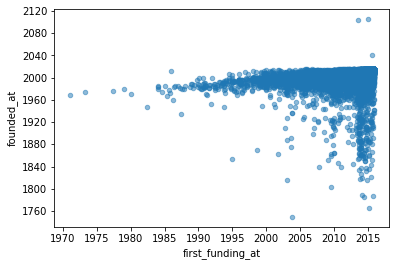

In [28]:
plt.scatter(companies['first_funding_at'], companies['founded_at'], s = 20, alpha = 0.5)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

We Noticed that there are some outliers than can be removed from the dataset so we will create a temporary dataframe that will contain the outliers so we can drop them later on. The first outliers that we want to deduct are the ones at the left of the center.

In [29]:
from datetime import datetime
tempdf = companies.copy()
tempdf = tempdf[(tempdf.first_funding_at <= datetime.strptime("01/01/1983", "%d/%m/%Y"))& (tempdf.founded_at <= datetime.strptime("01/01/2000", "%d/%m/%Y"))]
dropseries = tempdf.copy()
dropseries

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
744,/organization/abo-data,ABO Data,http://PLATONE.IO,Enterprise Software,1000000,operating,USA,TX,TX - Other,Italy,1,1979-01-01,1979-01-01,1979-01-01,0 days
3728,/organization/apple,Apple,http://www.apple.com,Computers|Consumer Electronics|Electronics|Har...,250000,ipo,USA,CA,SF Bay Area,Cupertino,1,1976-04-01,1977-05-15,1977-05-15,409 days
8786,/organization/buena-park-locksmith,Buena Park Locksmith,http://www.BuenaParkLocksmithCA.com,Local Businesses,-,operating,USA,CA,Anaheim,Buena Park,1,1974-11-20,1973-04-15,1973-04-15,-584 days
26908,/organization/ikro,Ikro,http://www.ikro.com.br/,Automotive|Heavy Industry|Manufacturing,724000,closed,BRA,23,BRA - Other,Canoas,1,1947-01-01,1982-06-01,1982-06-01,12935 days
28378,/organization/intercomp,Intercomp,NaN,NaN,549000,closed,NaN,NaN,NaN,NaN,1,1968-01-01,1971-01-01,1971-01-01,1096 days
36251,/organization/mitrol-2,Mitrol,NaN,NaN,9000000,closed,NaN,NaN,NaN,NaN,1,1971-01-01,1980-01-01,1980-01-01,3287 days


Plotting the outliers on a separate graph:

Text(0, 0.5, 'founded_at')

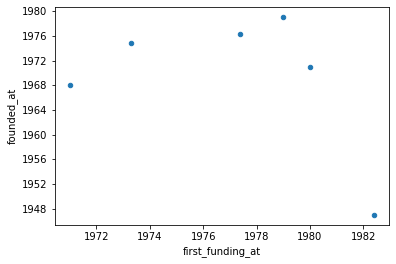

In [30]:
plt.scatter(tempdf['first_funding_at'], tempdf['founded_at'], s = 20)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

Now we will determine the outliers that are the bottom of the center from the original graph.

In [31]:
tempdf = companies.copy()
tempdf = tempdf[(tempdf.first_funding_at < datetime.strptime("01/01/2005", "%d/%m/%Y"))& (tempdf.founded_at <= datetime.strptime("01/01/1900", "%d/%m/%Y"))]
tempdf

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
4563,/organization/asia-pacific-marine-container-lines,Asia Pacific Marine Container Lines,http://AsiaPacificMarine.com,Logistics Company|Shipping|Shipping Broker Ind...,-,closed,CAN,BC,Vancouver,Vancouver,1,1870-01-05,1998-09-01,1998-09-01,46990 days
4748,/organization/athenix,Athenix,http://www.athenixcorp.com,Biotechnology,43500000,acquired,USA,NC,Raleigh,Raleigh,4,1863-01-01,2001-09-10,2008-07-23,50656 days
8240,/organization/boylan-bottling,Boylan Bottling,https://www.boylanbottling.com/,NaN,-,closed,USA,NY,New York City,New York,1,1891-01-01,2003-09-10,2003-09-10,41159 days
12370,/organization/coleman-natural-foods,Coleman Natural Foods,http://www.colemannatural.com/,Hospitality,9000000,operating,USA,NC,Asheville,Mountain Home,1,1875-01-01,2003-08-20,2003-08-20,46982 days
13513,/organization/counterpane-internet-security-in...,Counterpane Internet Security,http://www.counterpane.com,Risk Management|Sales and Marketing|Security,20000000,acquired,USA,CA,SF Bay Area,Cupertino,1,1888-01-01,2003-01-14,2003-01-14,42016 days
20690,/organization/fkk-corporation,FKK Corporation,http://www.fkk-corporation.com,Hardware + Software,-,operating,JPN,22,Kyoto,Kyoto-shi,1,1854-02-01,1995-01-01,1995-01-01,51468 days
47744,/organization/remington-arms-company,Remington Arms Company,http://www.remington.com/,Manufacturing|Outdoors|Sporting Goods,30000000,operating,USA,NC,Greensboro,Madison,1,1816-01-01,2003-01-10,2003-01-10,68310 days
49957,/organization/scottish-newcastle-plc,Scottish & Newcastle PLC,NaN,Brewing,4200000,operating,GBR,U8,Edinburgh,Edinburgh,1,1749-01-01,2003-10-10,2003-10-10,93053 days


Plotting the outliers on a separate graph:

Text(0, 0.5, 'founded_at')

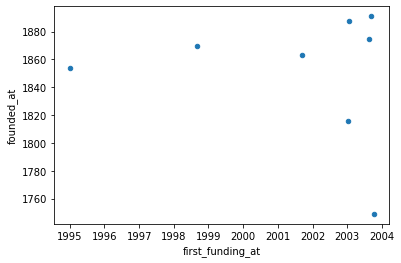

In [32]:
plt.scatter(tempdf['first_funding_at'], tempdf['founded_at'], s = 20)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

Now we will concatenate the newly discovered outliers to the ones from before

In [33]:
dropseries = pd.concat([dropseries, tempdf])
dropseries

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
744,/organization/abo-data,ABO Data,http://PLATONE.IO,Enterprise Software,1000000,operating,USA,TX,TX - Other,Italy,1,1979-01-01,1979-01-01,1979-01-01,0 days
3728,/organization/apple,Apple,http://www.apple.com,Computers|Consumer Electronics|Electronics|Har...,250000,ipo,USA,CA,SF Bay Area,Cupertino,1,1976-04-01,1977-05-15,1977-05-15,409 days
8786,/organization/buena-park-locksmith,Buena Park Locksmith,http://www.BuenaParkLocksmithCA.com,Local Businesses,-,operating,USA,CA,Anaheim,Buena Park,1,1974-11-20,1973-04-15,1973-04-15,-584 days
26908,/organization/ikro,Ikro,http://www.ikro.com.br/,Automotive|Heavy Industry|Manufacturing,724000,closed,BRA,23,BRA - Other,Canoas,1,1947-01-01,1982-06-01,1982-06-01,12935 days
28378,/organization/intercomp,Intercomp,NaN,NaN,549000,closed,NaN,NaN,NaN,NaN,1,1968-01-01,1971-01-01,1971-01-01,1096 days
36251,/organization/mitrol-2,Mitrol,NaN,NaN,9000000,closed,NaN,NaN,NaN,NaN,1,1971-01-01,1980-01-01,1980-01-01,3287 days
4563,/organization/asia-pacific-marine-container-lines,Asia Pacific Marine Container Lines,http://AsiaPacificMarine.com,Logistics Company|Shipping|Shipping Broker Ind...,-,closed,CAN,BC,Vancouver,Vancouver,1,1870-01-05,1998-09-01,1998-09-01,46990 days
4748,/organization/athenix,Athenix,http://www.athenixcorp.com,Biotechnology,43500000,acquired,USA,NC,Raleigh,Raleigh,4,1863-01-01,2001-09-10,2008-07-23,50656 days
8240,/organization/boylan-bottling,Boylan Bottling,https://www.boylanbottling.com/,NaN,-,closed,USA,NY,New York City,New York,1,1891-01-01,2003-09-10,2003-09-10,41159 days
12370,/organization/coleman-natural-foods,Coleman Natural Foods,http://www.colemannatural.com/,Hospitality,9000000,operating,USA,NC,Asheville,Mountain Home,1,1875-01-01,2003-08-20,2003-08-20,46982 days


Finally, we will deduct the outliers that are the top right corner

In [34]:
tempdf = companies.copy()
tempdf = tempdf[(tempdf.first_funding_at > datetime.strptime("01/01/2010", "%d/%m/%Y"))& (tempdf.founded_at >= datetime.strptime("01/01/2030", "%d/%m/%Y"))]
tempdf

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
16681,/organization/dugoutfc-ltd,DugoutFC Ltd,http://www.dugoutfc.com,Fantasy Sports,100000,operating,NaN,NaN,NaN,NaN,1,2105-02-17,2015-01-01,2015-01-01,-32919 days
32736,/organization/livamp-2,LIVAMP,http://www.livamp.com,Entertainment|Music|Video,300000,closed,NaN,NaN,NaN,NaN,1,2041-09-21,2015-08-31,2015-08-31,-9518 days
53396,/organization/soply,Soply,https://soply.com/,Creative Industries|Digital Media|Marketplaces,150000,operating,GBR,H9,London,London,1,2104-01-01,2013-07-01,2013-07-01,-33055 days


Visualizing the outliers:

Text(0, 0.5, 'founded_at')

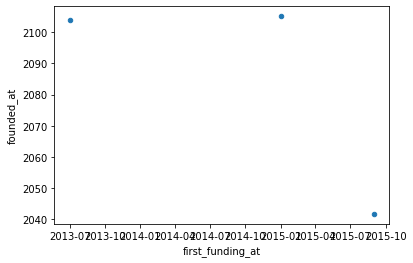

In [35]:
plt.scatter(tempdf['first_funding_at'], tempdf['founded_at'], s = 20)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

Concatinating the outliers on the rest:

In [36]:
dropseries = pd.concat([dropseries, tempdf])
dropseries

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
744,/organization/abo-data,ABO Data,http://PLATONE.IO,Enterprise Software,1000000,operating,USA,TX,TX - Other,Italy,1,1979-01-01,1979-01-01,1979-01-01,0 days
3728,/organization/apple,Apple,http://www.apple.com,Computers|Consumer Electronics|Electronics|Har...,250000,ipo,USA,CA,SF Bay Area,Cupertino,1,1976-04-01,1977-05-15,1977-05-15,409 days
8786,/organization/buena-park-locksmith,Buena Park Locksmith,http://www.BuenaParkLocksmithCA.com,Local Businesses,-,operating,USA,CA,Anaheim,Buena Park,1,1974-11-20,1973-04-15,1973-04-15,-584 days
26908,/organization/ikro,Ikro,http://www.ikro.com.br/,Automotive|Heavy Industry|Manufacturing,724000,closed,BRA,23,BRA - Other,Canoas,1,1947-01-01,1982-06-01,1982-06-01,12935 days
28378,/organization/intercomp,Intercomp,NaN,NaN,549000,closed,NaN,NaN,NaN,NaN,1,1968-01-01,1971-01-01,1971-01-01,1096 days
36251,/organization/mitrol-2,Mitrol,NaN,NaN,9000000,closed,NaN,NaN,NaN,NaN,1,1971-01-01,1980-01-01,1980-01-01,3287 days
4563,/organization/asia-pacific-marine-container-lines,Asia Pacific Marine Container Lines,http://AsiaPacificMarine.com,Logistics Company|Shipping|Shipping Broker Ind...,-,closed,CAN,BC,Vancouver,Vancouver,1,1870-01-05,1998-09-01,1998-09-01,46990 days
4748,/organization/athenix,Athenix,http://www.athenixcorp.com,Biotechnology,43500000,acquired,USA,NC,Raleigh,Raleigh,4,1863-01-01,2001-09-10,2008-07-23,50656 days
8240,/organization/boylan-bottling,Boylan Bottling,https://www.boylanbottling.com/,NaN,-,closed,USA,NY,New York City,New York,1,1891-01-01,2003-09-10,2003-09-10,41159 days
12370,/organization/coleman-natural-foods,Coleman Natural Foods,http://www.colemannatural.com/,Hospitality,9000000,operating,USA,NC,Asheville,Mountain Home,1,1875-01-01,2003-08-20,2003-08-20,46982 days


Now, we can drop all of the outliers that have been detected.


In [37]:
list = dropseries.index
companies = companies.drop(list)
#companies['time_before_first_fund'].sort_values(ascending=False)

Plotting the graph once more after cleaning:

Text(0, 0.5, 'founded_at')

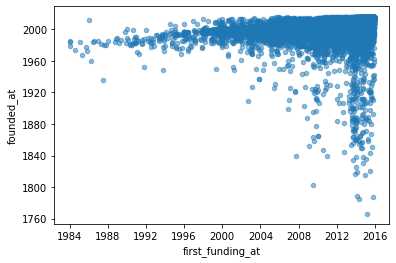

In [38]:
plt.scatter(companies['first_funding_at'], companies['founded_at'], s = 20, alpha=0.5)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

Now, we can calculate the mean. Notice that there were not much of a difference but deducting the outliers helped keeping the data realistic because some dates were 2090, 2100, etc. which is unrealistic.

In [39]:
companies['time_before_first_fund'].mean()

Timedelta('1363 days 03:13:16.759422320')

Filling the missing values with the new mean:

In [40]:
companies['time_before_first_fund'].fillna(companies['time_before_first_fund'].mean(), inplace = True)
companies['time_before_first_fund']

0       1363 days 03:13:16.759422320
1                -187 days +00:00:00
2       1363 days 03:13:16.759422320
3                  443 days 00:00:00
4                 1665 days 00:00:00
                    ...             
66363   1363 days 03:13:16.759422320
66364            -194 days +00:00:00
66365             1308 days 00:00:00
66366              365 days 00:00:00
66367   1363 days 03:13:16.759422320
Name: time_before_first_fund, Length: 66326, dtype: timedelta64[ns]

After calculating the mean and filling the nulls with it, now we can impute the missing dates in the 'founded_at' column by subtracting the time before first funding from the first funding date.

In [41]:
companies['founded_at'].fillna(companies['first_funding_at'] - companies['time_before_first_fund'], inplace = True)
companies['founded_at']

0       2011-04-12 20:46:43.240577680
1       2014-09-04 00:00:00.000000000
2       2010-05-07 20:46:43.240577680
3       2007-01-01 00:00:00.000000000
4       2010-01-01 00:00:00.000000000
                     ...             
66363   2008-07-07 20:46:43.240577680
66364   2012-05-13 00:00:00.000000000
66365   2011-01-01 00:00:00.000000000
66366   2014-01-01 00:00:00.000000000
66367   2010-01-06 20:46:43.240577680
Name: founded_at, Length: 66326, dtype: datetime64[ns]

Converting 'aquired_at' of the acquisitons dataset from Object to date:

In [42]:
acquis['acquired_at'] =pd.to_datetime(acquis['acquired_at'], errors = 'coerce')
acquis.dtypes

company_permalink                 object
company_name                      object
company_category_list             object
company_country_code              object
company_state_code                object
company_region                    object
company_city                      object
acquirer_permalink                object
acquirer_name                     object
acquirer_category_list            object
acquirer_country_code             object
acquirer_state_code               object
acquirer_region                   object
acquirer_city                     object
acquired_at               datetime64[ns]
acquired_month                    object
price_amount                     float64
price_currency_code               object
dtype: object

Converting 'funded_at' of the investments dataset from Object to date:

In [43]:
invests['funded_at'] =pd.to_datetime(invests['funded_at'], errors = 'coerce')
invests.dtypes

company_permalink                  object
company_name                       object
company_category_list              object
company_country_code               object
company_state_code                 object
company_region                     object
company_city                       object
investor_permalink                 object
investor_name                      object
investor_country_code              object
investor_state_code                object
investor_region                    object
investor_city                      object
funding_round_permalink            object
funding_round_type                 object
funding_round_code                 object
funded_at                  datetime64[ns]
raised_amount_usd                 float64
dtype: object

Converting 'funded_at' of the rounds dataset from Object to date:

In [44]:
rounds['funded_at'] =pd.to_datetime(rounds['funded_at'], errors = 'coerce')
rounds.dtypes

company_permalink                  object
company_name                       object
company_category_list              object
company_country_code               object
company_state_code                 object
company_region                     object
company_city                       object
funding_round_permalink            object
funding_round_type                 object
funding_round_code                 object
funded_at                  datetime64[ns]
raised_amount_usd                 float64
dtype: object

## Imputing Categories

Regarding the category list in the five datasets, since we don't have any indicator on deducing the null values in this column, we will fill the nulls with "missing". With samples, it's provided that the same rows (companies) that their category is missing in one dataset, are the same rows in the others so even merging the datasets will not be helpful.


In [45]:
companies['company_category_list'].fillna('missing', inplace=True)
acquis['company_category_list'].fillna('missing', inplace=True)
acquis['acquirer_category_list'].fillna('missing', inplace=True)
invests['company_category_list'].fillna('missing', inplace=True)
rounds['company_category_list'].fillna('missing', inplace=True)

## Imputing Raised Amount

There are alot of missing data in the raised amount column in the data set. One strategy that could be taken is calculating the mean of all of the funds of this certain company and impute its nulls with the average of total fund it has recieved before. First we calculate the mean of of the total funding of each company then add it in a new row, then compare each row if the raised amount column is null, then fill it with the average of the company otherwise leave it as it is.

In [57]:
total = invests.groupby(['company_name'])['raised_amount_usd'].transform(np.mean)
total = pd.DataFrame(total)
invests['total_raised'] = total
invests['raised_amount_usd'] = np.where((invests['raised_amount_usd'].isnull()), invests['total_raised'], invests['raised_amount_usd'])
invests['raised_amount_usd'].fillna(invests['raised_amount_usd'].mean(), inplace = True)
invests

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,total_raised
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,23,Shanghai,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2.000000e+06,2.000000e+06
1,/organization/004-technologies,004 Technologies,Software,USA,IL,"Springfield, Illinois",Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,5,Frankfurt,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,1.493930e+07,1.493930e+07
2,/organization/01games-technology,01Games Technology,Games,HKG,NaN,Hong Kong,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,NaN,Hong Kong,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,2014-07-01,4.125000e+04,4.125000e+04
3,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/capital-one,Capital One,USA,VA,"Washington, D.C.",Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,2.000000e+07,1.010714e+07
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3.000000e+06,1.010714e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168642,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,Advertising|Mobile|Web Development|Wireless,HRV,15,Split,Split,/organization/eleven,Eleven,BGR,42,Sofia,Sofia,/funding-round/ff1aa06ed5da186c84f101549035d4ae,seed,NaN,2013-05-01,3.284200e+04,3.576800e+04
168643,/organization/Áeron,ÁERON,missing,NaN,NaN,NaN,NaN,/organization/day-one-capital,Day One Capital Fund Management,HUN,5,Budapest,Budapest,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,2014-08-01,1.493930e+07,1.493930e+07
168644,/organization/Áeron,ÁERON,missing,NaN,NaN,NaN,NaN,/organization/sz-chenyi-capital-fund-management,Széchenyi Capital Fund Management,NaN,NaN,NaN,NaN,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,2014-08-01,1.493930e+07,1.493930e+07
168645,/organization/Ôasys-2,Ôasys,Consumer Electronics|Internet of Things|Teleco...,USA,CA,SF Bay Area,San Francisco,/organization/startupbootcamp,Startupbootcamp,GBR,H9,London,London,/funding-round/35f09d0794651719b02bbfd859ba9ff5,seed,NaN,2015-01-01,1.819200e+04,1.819200e+04


In [47]:
#farah stop point here

## Cleaning & Imputing Geographical Locations

### Removing `company_state_code` and `company_region`

We don't need `company_state_code` in our analysis, <br>
As country code and city are sufficient to know <br>
an approximation of the geographical location of the company. <br>
Therefore, let's remove it:

In [48]:
companies[['company_country_code', 'company_state_code', 'company_city']].head(10)

,company_country_code,company_state_code,company_city
0,IND,16,Mumbai
1,USA,DE,Delaware City
2,NaN,NaN,NaN
3,CHN,22,Beijing
4,USA,IL,Champaign
5,HKG,NaN,Hong Kong
6,CAN,BC,Vancouver
7,USA,CA,Mountain View
8,USA,CA,San Francisco
9,CHL,12,Las Condes


In [49]:
companies.drop('company_state_code', axis=1, inplace=True)

`company_region` is also redundent, as it is usually the same as `company_city`.<br>
Let's validate this:

In [50]:
# Note: same logic applies for the permalinks
acquis.dropna(subset=['acquirer_permalink', 'acquirer_name'], inplace=True)
invests.dropna(subset=['investor_permalink', 'investor_name'], inplace=True)

Also, we'll remove the missing values for columns that have less than 100 `NaN`, <br>
as they're small in comparison to their respective datasets:

In [51]:
companies[companies.company_region == companies.company_city][['company_region', 'company_city']]

,company_region,company_city
0,Mumbai,Mumbai
3,Beijing,Beijing
5,Hong Kong,Hong Kong
6,Vancouver,Vancouver
11,Orlando,Orlando
...,...,...
66354,Bath,Bath
66360,Milwaukee,Milwaukee
66362,London,London
66363,Beijing,Beijing


Let's see the mean of similarity between the strings using builtin library `difflib.SequenceMatcher`:

In [52]:
from difflib import SequenceMatcher
similarities = []
rgs = companies.company_region.values.tolist()
cts = companies.company_city.values.tolist()
for i in range(min(len(rgs), len(cts))):
    if not (rgs[i] != rgs[i] or cts[i] != cts[i]): # If either of the elements is NaN, then don't find the similarity
        similarities.append(SequenceMatcher(None, rgs[i], cts[i]).ratio()) # Gets the similarity between each two strings
avgSim = sum(similarities) / len(similarities)
avgSim

0.6175397944380312

However, `SequenceMatcher` only finds the longest contiguous matching subsequence, <br>
and all other characters will drastically decrease the similarity, which isn't very accurate, <br>
Therefore, let's try to see how many times a string is a substring of another:

In [53]:
subsCount = 0
for i in range(min(len(rgs), len(cts))):
    if not (rgs[i] != rgs[i] or cts[i] != cts[i]):
        subsCount += (rgs[i] in cts[i] or cts[i] in rgs[i])
subsCount

29878

So to summarize: almost half of the companies have the same data for `region` and `city` (25360) <br>
There are around 5000 companies that have the same semantic meaning between the data <br>
(e.g: 'New York City' is the same as 'NYC, New York City') <br>
Therefore, `company_region` can be removed without losing any possible future insights:

In [54]:
companies.drop('company_region', axis=1, inplace=True)

In [58]:
for df in dfAll:
    nulls = df.isnull().sum()
    cols = nulls[(nulls <= 100) & (nulls != 0)].index.tolist()
    df.dropna(subset=cols, inplace=True)
dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
dfAllNulls

,acquisitions,nulls_1,companies,nulls_2,investments,nulls_3,rounds,nulls_4
0,company_permalink,0.0,company_permalink,0.0,company_permalink,0,company_permalink,0.0
1,company_name,0.0,company_name,0.0,company_name,0,company_name,0.0
2,company_category_list,0.0,homepage_url,5058.0,company_category_list,0,company_category_list,0.0
3,company_country_code,4661.0,company_category_list,3147.0,company_country_code,10521,company_country_code,8678.0
4,company_state_code,4940.0,funding_total_usd,0.0,company_state_code,13431,company_state_code,10946.0
5,company_region,4902.0,status,0.0,company_region,12485,company_region,10167.0
6,company_city,4902.0,company_country_code,6956.0,company_city,12483,company_city,10164.0
7,acquirer_permalink,0.0,company_state_code,8545.0,investor_permalink,0,funding_round_permalink,0.0
8,acquirer_name,0.0,company_region,8028.0,investor_name,0,funding_round_type,0.0
9,acquirer_category_list,0.0,company_city,8026.0,investor_country_code,30927,funding_round_code,83808.0


### Imputing `company_country_code` and `company_city`

#### Failed attempt using `company_permalink`:
1. check the company's permalink
2. find HTML that contains the headquarters location (country and city)
3. scrape country and convert it to country code using `pycountry.countries`
4. scrape city and impute it in `company_city`

Step 1: appending "https://www.crunchbase.com" to each permalink <br>
to be able to access the company's webpage on crunchbase. <br>
However, since the new permalink will be much longer (thus slower for accessing as a dataset's primary index) <br>
we'll create a function that appends the string as a prefix and that will be accessed throughout the notebook

Step 2: Finding location of country and city on the webpage:
let's check company [004](https://www.crunchbase.com/organization/004)'s webpage for example: <Br>
<img src="Phase 1/countryAndCityInCrunchbase.png" width=400 height=300 />

By inspecting the HTML, we notice 4 instances of the class <br>
`component--field-formatter field-type-identifier-multi` (in a `span` element),<br>and the data that we want
is always the first instance: <br>
<img src="Phase 1/countryAndCityLocationInHTML.png" width=700 height=500 />

Step 3: scrape that info using `requests` and `bs4` libraries: <br>
(Note, we're using `threading.Thread` here to increase performance by scraping in multithreads)

However, this is a deadend, as crunchbase is powered by [distill network](https://www.google.com/search?q=distil+network&sxsrf=APq-WBt2mubTHz1xGfmKgpzlWtHah5qAaA%3A1648578960023&ei=kFFDYsx646qVB_nKh7gK&ved=0ahUKEwjMgq-a--v2AhVjVeUKHXnlAacQ4dUDCA4&uact=5&oq=distil+network&gs_lcp=Cgdnd3Mtd2l6EAMyBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjoHCCMQsAMQJzoHCAAQRxCwA0oECEEYAEoECEYYAFCyCliyCmCLD2gBcAF4AIABowGIAaMBkgEDMC4xmAEAoAEByAEKwAEB&sclient=gws-wiz#:~:text=distil%20networks%20uses%20machine%20learning%20to%20identify%20and%20mitigate%20potential%20bad%20bots%2C%20fingerprinting%20them%20so%20that%20they%20can%20still%20be%20tracked%20if%20they%20reconnect%20from%20a%20different%20ip%20address) <br>
So when we tried to scrap from it, the following html was always displayed: <br><br>
<img src="Phase 1/crunchbaseAccessDenied.png">

#### Failed attempt using [linkedin](https://www.linkedin.com/in/ashrafharess/)

It failed because after a while, linkedin detects that you are a bot: <br><br>
<img src='Phase 1/linkedinSecurityCheck.png' width=500 height=300>

However, the steps are displayed below to show how this was initially done using multithreads:

Step 1: Login into linkedin using `selenium.webdriver`:

In [81]:
from selenium import webdriver
import time
import warnings
warnings.filterwarnings('ignore') # to suppress warnings about internal code deprecations
options=webdriver.ChromeOptions()
options.add_argument('--incognito')
options.add_argument('--headless')
driver=webdriver.Chrome(options=options)
driver.get('https://www.linkedin.com/uas/login')

username = driver.find_element_by_id('username')
username.send_keys('ashraf196280@bue.edu.eg')
password = driver.find_element_by_id('password')
password.send_keys('0LinkedIn0')
log_in_button = driver.find_element_by_class_name('from__button--floating')
log_in_button.click()

Step 2: Visualize the html of the data you need to scrape: <br><br>
<img src='Phase 1/linkedinAboutLocations.png' width=800 height=500>

In [78]:
driver.get('https://www.linkedin.com/company/absolvent/about/')
time.sleep(3) # sleeping to render javascript code before parsing to BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

WebDriverException: Message: unknown error: net::ERR_INTERNET_DISCONNECTED
  (Session info: headless chrome=100.0.4896.60)
Stacktrace:
Backtrace:
	Ordinal0 [0x01179943+2595139]
	Ordinal0 [0x0110C9F1+2148849]
	Ordinal0 [0x01004528+1066280]
	Ordinal0 [0x01000DB4+1052084]
	Ordinal0 [0x00FF63BD+1008573]
	Ordinal0 [0x00FF6F7C+1011580]
	Ordinal0 [0x00FF65CA+1009098]
	Ordinal0 [0x00FF5BC6+1006534]
	Ordinal0 [0x00FF4AD0+1002192]
	Ordinal0 [0x00FF4FAD+1003437]
	Ordinal0 [0x01005C4A+1072202]
	Ordinal0 [0x0105C19D+1425821]
	Ordinal0 [0x0104B9EC+1358316]
	Ordinal0 [0x0105BAF2+1424114]
	Ordinal0 [0x0104B806+1357830]
	Ordinal0 [0x01026086+1204358]
	Ordinal0 [0x01026F96+1208214]
	GetHandleVerifier [0x0131B232+1658114]
	GetHandleVerifier [0x013D312C+2411516]
	GetHandleVerifier [0x0120F261+560433]
	GetHandleVerifier [0x0120E366+556598]
	Ordinal0 [0x0111286B+2173035]
	Ordinal0 [0x011175F8+2192888]
	Ordinal0 [0x011176E5+2193125]
	Ordinal0 [0x011211FC+2232828]
	BaseThreadInitThunk [0x7769FA29+25]
	RtlGetAppContainerNamedObjectPath [0x77927A7E+286]
	RtlGetAppContainerNamedObjectPath [0x77927A4E+238]


In [77]:
locCard = soup.find('div', 'org-location-card pv2')
locCard.text

AttributeError: 'NoneType' object has no attribute 'text'

In [ ]:
import re
re.findall(r'Primary[\n\s]+(\w+)', locCard.text)

['Warsaw']

Step 3: Visualize another part of the html in case step 3 doesn't work: <br><br>
<img src='Phase 1/linkedinAboutHeadquarters.png' width=700 height=500>

In [ ]:
driver.get('https://www.linkedin.com/company/association-for-computing-machinery/about/')
time.sleep(3) # sleeping to render javascript code before parsing to BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [ ]:
dl = soup.find('div', 'mb6').find('dl')
dl

<dl class="overflow-hidden">
<dt class="mb1 text-heading-small">
          Website
        </dt>
<dd class="mb4 text-body-small t-black--light">
<a class="link-without-visited-state ember-view" href="https://www.acm.org/" id="ember61" rel="noopener noreferrer" tabindex="0" target="_blank">
<span class="link-without-visited-state" dir="ltr">
              https://www.acm.org/
            </span>
</a>
</dd>
<dt class="mb1 text-heading-small">
          Phone
        </dt>
<dd class="mb4 text-body-small t-black--light">
<a class="link-without-visited-state ember-view" href="tel:+1 (212) 626-0500" id="ember62" rel="noopener noreferrer" tabindex="0" target="_blank">
<span aria-hidden="true" class="link-without-visited-state" dir="ltr">
              +1 (212) 626-0500
            </span>
<span class="visually-hidden">
              Phone number is +1 (212) 626-0500
            </span>
</a>
</dd>
<dt class="mb1 text-heading-small">
            Industry
          </dt>
<dd class="mb4 text-body

In [ ]:
dl = soup.find('div', 'mb6').find('dl')
nms = []
for tag in dl:
    txt = tag.text
    nms.append(txt)
nms

['\n',
 '\n          Website\n        ',
 '\n',
 '\n\n\n              https://www.acm.org/\n            \n\n',
 '\n',
 '\n          Phone\n        ',
 '\n',
 '\n\n\n              +1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500\n            \n\n',
 '\n',
 '\n            Industry\n          ',
 '\n',
 '\n            Book and Periodical Publishing\n          ',
 '\n',
 '\n          Company size\n        ',
 '\n',
 '\n            51-200 employees\n        ',
 '\n',
 '\n            1,195 on LinkedIn\n            \n \n\n\n\n    Includes members with current employer listed as ACM, Association for Computing Machinery, including part-time roles.\n\n\n\n',
 '\n',
 '\n            Headquarters\n          ',
 '\n',
 '\n            New York, NY\n          ',
 '\n',
 '',
 '\n',
 '\n          Founded\n        ',
 '\n',
 '\n          1947\n        ',
 '\n',
 '\n          Specialties\n        ',
 '\n',
 '\n          Computing\n        ',
 '\n']

In [ ]:
# getting the values in key-value pairs, then we will extract the country from key "Headquarters"
dl = soup.find('div', 'mb6').find('dl')
keys = []
values = []
for tag in dl.find_all('dt'):
    txt = tag.text.strip()
    if (txt != ''):
        keys.append(txt)
for tag in dl.find_all('dd'):
    txt = tag.text.strip()
    if (txt != ''):
        values.append(txt)


In [ ]:
keys, values

(['Website',
  'Phone',
  'Industry',
  'Company size',
  'Headquarters',
  'Founded',
  'Specialties'],
 ['https://www.acm.org/',
  '+1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500',
  'Book and Periodical Publishing',
  '51-200 employees',
  '1,195 on LinkedIn\n            \n \n\n\n\n    Includes members with current employer listed as ACM, Association for Computing Machinery, including part-time roles.',
  'New York, NY',
  '1947',
  'Computing'])

In [ ]:
values = [txt for txt in values if "Includes" not in txt] # a message which contains the word "Includes" sometime appears and is not needed, thus we don't include it
values

['https://www.acm.org/',
 '+1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500',
 'Book and Periodical Publishing',
 '51-200 employees',
 'New York, NY',
 '1947',
 'Computing']

In [ ]:
# putting the key-value pairs in a dictionary
linkedinDict = dict(zip(keys, values))
linkedinDict

{'Website': 'https://www.acm.org/',
 'Phone': '+1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500',
 'Industry': 'Book and Periodical Publishing',
 'Company size': '51-200 employees',
 'Headquarters': 'New York, NY',
 'Founded': '1947',
 'Specialties': 'Computing'}

In [ ]:
linkedinDict["Headquarters"]

'New York, NY'

Step 4: getting the country code of the companies and their corresponding indices and putting them in a list of tuples:

In [ ]:
import threading # using multithreads to speed things up a little
lock = threading.Lock()
import pycountry
from geopy.geocoders import Nominatim # using this library to convert cities to countries
import time
import re

geolocator = Nominatim(user_agent="ashraf196280@bue.edu.eg")

idxToNan = []
def fetchCountry(idx, link):
    try:
        lock.acquire()
        driver.get(link) # same driver used from step 1
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        lock.release()
        dl = soup.find('div', 'mb6').find('dl')
        keys = []
        values = []
        for tag in dl.find_all('dt'):
            txt = tag.text.strip()
            if (txt != ''):
                keys.append(txt)
        for tag in dl.find_all('dd'):
            txt = tag.text.strip()
            if (txt != ''):
                values.append(txt)
        values = [txt for txt in values if "Includes" not in txt]
        linkedinDict = dict(zip(keys, values))
        if ('Headquarters' in linkedinDict):
            city = linkedinDict["Headquarters"]
            city = city.split(',')[0] # eg: "Cupertino, California" will be ["Cupertino", "California"], so "Cupertino" will be returned
        else:
            locCard = soup.find('div', 'org-location-card pv2')
            city = re.findall(r'Primary[\n\s]+(\w+)', locCard.text)[0]
        lock.acquire()
        location = geolocator.geocode(city, language="en")
        lock.release()
        if location is None:
            raise
    except:
        lock.acquire()
        idxToNan.append((idx, "missing")) # means that this website is not found on linkedin, so declare it as missing
        lock.release()
        return
    
    country = location.address.split(', ')[-1]
    try:
        alpha3Code = pycountry.countries.get(name=country).alpha_3
    except:
        alpha3Code = country[0:3].upper() #if not found in pycountry, assume that it is the first 3 letters of the country name
    lock.acquire()
    idxToNan.append((idx, alpha3Code))
    lock.release()


In [ ]:
from threading import Thread
def imputeFromLinks(df, colToSuffixIntoURL, colToImpute, linkPrefix = "", start, end):
    links = df[df[colToImpute].isnull()][[colToSuffixIntoURL]].squeeze()[start:end] # "squeeze()" converts df to series
    threads = []
    for tup in links.iteritems(): # tup[0] --> index, tup[1] --> url (i.e. link)
        th = Thread(target=fetchCountry, args=(tup[0], linkPrefix + tup[1].replace(" ", "") + '/about')) #making sure company name doesn't have spaces when suffixed into the url
        threads.append(th)
        th.start()
    for th in threads:
        th.join() # to wait until all multithreads finish to properly display the dataframe

In [ ]:
# single threaded version (just in case multithreads gets blocked by linkedin)
from threading import Thread
def imputeFromLinksSingleThreads(df, colToSuffixIntoURL, colToImpute, linkPrefix = ""):
    links = df[df[colToImpute].isnull()][[colToSuffixIntoURL]].squeeze() # "squeeze()" converts df to series
    for tup in links.iteritems(): # tup[0] --> index, tup[1] --> url (i.e. link)
        fetchCountry(tup[0], linkPrefix + tup[1].replace(" ", "") + '/about') #making sure company name doesn't have spaces when suffixed into the url
        

In [ ]:
links = companies[companies['company_country_code'].isnull()][['company_name']].squeeze()
len(links)

NameError: name 'companies' is not defined

In [ ]:
imputeFromLinks(companies, "company_name", "company_country_code", "https://www.linkedin.com/company/")

Moscow


In [ ]:
idxToNan

[(21, 'missing'),
 (35, 'missing'),
 (39, 'RUS'),
 (45, 'missing'),
 (57, 'missing')]

In [ ]:
dfLinkedin = pd.DataFrame(idxToNan, columns=['index', 'company_country_code'])
dfLinkedin.set_index('index')
dfLinkedin.to_csv('Phase 1/countryCodesLinkedIn.csv', index=False)

#### Successful attempt using TLDs of `homepage_url`

Let's check the top level domain (TLD) of each link using regex and see if we can use that <br>
to impute the country code:

In [59]:
# As you can see, there are only approximately 1500 rows that don't contain neither country_code nor homepage_url
hUrls = companies[companies['company_country_code'].isnull()][['homepage_url']].squeeze()
hUrls.dropna(inplace=True)
len(hUrls), len(companies[companies['company_country_code'].isnull()])

(5548, 6952)

In [60]:
hUrls.head(3)

2         http://oneofthem.jp
21    http://www.1000chi.com/
35    http://beansaround.com/
Name: homepage_url, dtype: object

In [61]:
hUrls.str.findall(r'(\.[^.]*)$').head(3) # use '\.([^.]*)$' if you don't want the '.', but we do, so leave it

2       [.jp]
21    [.com/]
35    [.com/]
Name: homepage_url, dtype: object

In [62]:
hUrls = hUrls.str.findall(r'(\.[^.]*)$').apply(lambda x : ''.join(x).split('/')[0]) # apply() will convert the list of strings to a string and remove '/' at the end of the string
hUrls

2         .jp
21       .com
35       .com
39       .com
45       .com
         ... 
66317    .com
66325     .co
66333    .com
66365     .hu
66367    .com
Name: homepage_url, Length: 5548, dtype: object

In [63]:

unwantedVals = hUrls.str.contains(pat='^$|com') # "^$" means empty string, "|" means "or"
hUrls = hUrls[~unwantedVals] # "~" is equivalent to "unwantedVals == False"
hUrls

2           .jp
54          .br
79       .media
126         .hk
159         .me
          ...  
66220       .cz
66230       .my
66270      .php
66325       .co
66365       .hu
Name: homepage_url, Length: 1541, dtype: object

Create a dictionary where key = TLD, value = country <br>
e.g --> '.jp' : 'Japan'

In [64]:
#csv obtained from https://gist.github.com/derlin/421d2bb55018a1538271227ff6b1299d#file-country-codes-tlds-csv
tldsToCountries = pd.read_csv('Phase 1/country-codes-tlds.csv')
tldsToCountries.drop_duplicates(subset='tld', keep='first', inplace=True)
tldsToCountries['tld'] = tldsToCountries['tld'].apply(lambda x: x.replace(' ', ''))
tldsToCountries.to_csv(r'Phase 1/newCountryCodesTlds.csv', index = None, header=True)
tldsToCountries = tldsToCountries.set_index('tld').squeeze()
tldsToCountries = tldsToCountries.to_dict()
tldsToCountries['.jp']

'Japan'

Use that dictionary to convert TLDs to their respective countries:

In [65]:
hCompanyLocs = hUrls.copy()
hCompanyLocs = hCompanyLocs.apply(lambda x : tldsToCountries[x] if (x in tldsToCountries) else 'none')
hCompanyLocs = hCompanyLocs[hCompanyLocs != 'none']
hCompanyLocs

2                           Japan
54                         Brazil
126                     Hong Kong
159                    Montenegro
281                   Switzerland
                   ...           
66184              Réunion Island
66220    Czechia (Czech Republic)
66230                    Malaysia
66325                    Colombia
66365                     Hungary
Name: homepage_url, Length: 1213, dtype: object

In [66]:
# 1213 countries could be imputed
len(hCompanyLocs)

1213

Convert those countries to country codes:

In [67]:
import pycountry
def toAlphaCode3(country):
    countryInfo = pycountry.countries.get(name=country)
    if (countryInfo is None):
        return "none"
    return countryInfo.alpha_3

hCompanyLocs = hCompanyLocs.apply(lambda x : toAlphaCode3(x))
hCompanyLocs = hCompanyLocs[hCompanyLocs != 'none']
hCompanyLocs

2        JPN
54       BRA
126      HKG
159      MNE
281      CHE
        ... 
65745    SVK
66120    POL
66230    MYS
66325    COL
66365    HUN
Name: homepage_url, Length: 900, dtype: object

In [68]:
# only 900 countries have country codes present, so impute those only
# the following is just to illustrate the for loop in the next cell:
hCompanyLocs.index[0], hCompanyLocs.iloc[0]

(2, 'JPN')

impute into `country_codes` of `companies` dataset

In [69]:
for i in range(len(hCompanyLocs)):
    idx = hCompanyLocs.index[i]
    code = hCompanyLocs.iloc[i]
    companies.at[idx, 'company_country_code'] = code

## Checking All `dtypes`

In [ ]:
def datasetsDtypes(dfList, datasetNames, dtypesCol="dtypes_", pad=""):
    cols = []
    nulls = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        nulls.append(df.dtypes.tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        nulls[i] += [None] *  (maxArrayLen - len(nulls[i]))
        dictCsvs[datasetNames[i]] = cols[i]
        dictCsvs[dtypesCol + str(i+1)] = nulls[i]
    
    return pd.DataFrame(dictCsvs)

In [ ]:
datasetsDtypes(dfAll, lstCsvNames)

,acquisitions,dtypes_1,companies,dtypes_2,investments,dtypes_3,rounds,dtypes_4
0,company_permalink,object,company_permalink,object,company_permalink,object,company_permalink,object
1,company_name,object,company_name,object,company_name,object,company_name,object
2,company_category_list,object,homepage_url,object,company_category_list,object,company_category_list,object
3,company_country_code,object,company_category_list,object,company_country_code,object,company_country_code,object
4,company_state_code,object,funding_total_usd,object,company_state_code,object,company_state_code,object
5,company_region,object,status,object,company_region,object,company_region,object
6,company_city,object,company_country_code,object,company_city,object,company_city,object
7,acquirer_permalink,object,company_city,object,investor_permalink,object,funding_round_permalink,object
8,acquirer_name,object,funding_rounds,int64,investor_name,object,funding_round_type,object
9,acquirer_category_list,object,founded_at,datetime64[ns],investor_country_code,object,funding_round_code,object


In [ ]:
#AISHA: VISUALIZE

In [ ]:
print("Aisha is happy ^^")

Aisha is happy ^^


In [ ]:
#Aisha stop

## `rounds` Dataset

In [ ]:
dfAllCols.iloc[:, -2:]

,investments,rounds
0,company_permalink,company_permalink
1,company_name,company_name
2,company_category_list,company_category_list
3,company_country_code,company_country_code
4,company_state_code,company_state_code
5,company_region,company_region
6,company_city,company_city
7,investor_permalink,funding_round_permalink
8,investor_name,funding_round_type
9,investor_country_code,funding_round_code


In [ ]:
invests.shape, rounds.shape

((168634, 18), (114948, 12))

In [ ]:
invests.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,23,Shanghai,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,3/19/2008,2000000.0
1,/organization/004-technologies,004 Technologies,Software,USA,IL,"Springfield, Illinois",Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,5,Frankfurt,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,7/24/2014,NaN
2,/organization/01games-technology,01Games Technology,Games,HKG,NaN,Hong Kong,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,NaN,Hong Kong,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,7/1/2014,41250.0
3,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/capital-one,Capital One,USA,VA,"Washington, D.C.",Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,11/9/2015,20000000.0
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,5/22/2013,3000000.0


In [ ]:
rounds.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,16,Mumbai,Mumbai,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,1/5/2015,10000000.0
1,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,10/14/2014,NaN
2,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,3/1/2014,700000.0
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,NaN,NaN,NaN,NaN,/funding-round/650b8f704416801069bb178a1418776b,venture,B,1/30/2014,3406878.0
4,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,3/19/2008,2000000.0


In [ ]:
len(invests["company_name"].unique()), len(rounds["company_name"].unique())

(44577, 66102)

Since there are companies in `rounds` dataset that are not in `investments` dataset, <br>
therefore we should keep `rounds` dataset for further analysis.

## `companies` Dataset

we will need to remove the none values of the following columns <br>
based on the question that we are trying to gain insight for: <br>
1.	Can the factors that affect a start-up’s growth be determined?
    -	For this: We are initially interested in <br> `funding_total_usd`, `status`, `funding_rounds`, `first_funding_at`, and `last_funding_at`
    -   So we could remove the 24 null values of `first_funding_at` since they are so small <br>
        compared to the rest of the dataset
2.  Do taxes play an important factor in deciding a start-up’s success?

